In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


font_path = 'C:/Users/User/OneDrive - 강남대학교/문서/malgun.ttf' 

# 폰트 설정
fontprop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = fontprop.get_name()

In [119]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
info = pd.read_csv('Data/data_info.csv')
submission= pd.read_csv('Data/sample_submission.csv')

# EDA

In [8]:
print(train.shape)
print(test.shape)
train.head()

(4701217, 23)
(291241, 22)


,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [9]:
info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [121]:
# 컬름이릉 영어에서 한국말로 변역

dictionary = {}
for i in range(24):
    key = info.iloc[i, 0]
    value = info.iloc[i, 1]
    
    dictionary[key] = value
    
train = train.rename(columns = dictionary)
test = test.rename(columns = dictionary)
train.head(5)

,아이디,날짜,요일,시간대,차로수,도로등급,도로명,중용구간 여부,연결로 코드,최고속도제한,...,도로유형,시작지점명,시작지점의 위도,시작지점의 경도,시작 지점의 회전제한 유무,도착지점명,도착지점의 위도,도착지점의 경도,도작지점의 회전제한 유무,평균속도(km)
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [12]:
# nunique 값이랑 dtype을 함께 조회

column_nunique = train.nunique()

for column, unique_count in zip(column_nunique.index, column_nunique.values):
    print(f"Column '{column}' has {unique_count} unique values.")
    
column_info = pd.DataFrame({'nunique': train.nunique(), 'dtype': train.dtypes})
column_info

Column '아이디' has 4701217 unique values.
Column '날짜' has 281 unique values.
Column '요일' has 7 unique values.
Column '시간대' has 24 unique values.
Column '차로수' has 3 unique values.
Column '도로등급' has 3 unique values.
Column '도로명' has 61 unique values.
Column '중용구간 여부' has 2 unique values.
Column '연결로 코드' has 2 unique values.
Column '최고속도제한' has 6 unique values.
Column '통과제한차량' has 1 unique values.
Column '통과제한하중' has 4 unique values.
Column '통과제한높이' has 1 unique values.
Column '도로유형' has 2 unique values.
Column '시작지점명' has 487 unique values.
Column '시작지점의 위도' has 586 unique values.
Column '시작지점의 경도' has 586 unique values.
Column '시작 지점의 회전제한 유무' has 2 unique values.
Column '도착지점명' has 487 unique values.
Column '도착지점의 위도' has 586 unique values.
Column '도착지점의 경도' has 586 unique values.
Column '도작지점의 회전제한 유무' has 2 unique values.
Column '평균속도(km)' has 102 unique values.


,nunique,dtype
아이디,4701217,object
날짜,281,int64
요일,7,object
시간대,24,int64
차로수,3,int64
도로등급,3,int64
도로명,61,object
중용구간 여부,2,int64
연결로 코드,2,int64
최고속도제한,6,float64


In [13]:
# nunique가 10 이하이며 dtype이 object인 칼럼을 category 로 변환

for column in column_info.index:
    if column_info.loc[column, 'nunique'] <= 10 and column_info.loc[column, 'dtype'] == 'object':
        train[column] = train[column].astype('category')

        
# nunique가 5 이하이며 dtype이 int64 혹은 float64인 경우 각각 int8, float16로 변환
for column in column_info.index:
    if column_info.loc[column, 'dtype'] in ['int64', 'float64'] and column_info.loc[column, 'nunique'] <= 5:
        if column_info.loc[column, 'dtype'] == 'int64':
            train[column] = train[column].astype(np.int8)
        else:
            train[column] = train[column].astype(np.float16)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column          Dtype   
---  ------          -----   
 0   아이디             object  
 1   날짜              int64   
 2   요일              category
 3   시간대             int64   
 4   차로수             int8    
 5   도로등급            int8    
 6   도로명             object  
 7   중용구간 여부         int8    
 8   연결로 코드          int8    
 9   최고속도제한          float64 
 10  통과제한차량          float16 
 11  통과제한하중          float16 
 12  통과제한높이          float16 
 13  도로유형            int8    
 14  시작지점명           object  
 15  시작지점의 위도        float64 
 16  시작지점의 경도        float64 
 17  시작 지점의 회전제한 유무  category
 18  도착지점명           object  
 19  도착지점의 위도        float64 
 20  도착지점의 경도        float64 
 21  도작지점의 회전제한 유무   category
 22  평균속도(km)        float64 
dtypes: category(3), float16(3), float64(6), int64(2), int8(5), object(4)
memory usage: 493.2+ MB


## memory usage 820MB --> 493MB

In [15]:
train['시작지점_위경도_벡터'] = np.sqrt(train['시작지점의 위도']**2 + train['시작지점의 경도']**2)
train['도착지점_위경도_벡터'] = np.sqrt(train['도착지점의 위도']**2 + train['도착지점의 경도']**2)

test['시작지점_위경도_벡터'] = np.sqrt(test['시작지점의 위도']**2 + test['시작지점의 경도']**2)
test['도착지점_위경도_벡터'] = np.sqrt(test['도착지점의 위도']**2 + test['도착지점의 경도']**2)

train.drop(['아이디', '시작지점의 위도', '시작지점의 경도','도착지점의 위도','도착지점의 경도'], 
           axis=1, inplace=True)
test.drop(['아이디','시작지점의 위도', '시작지점의 경도','도착지점의 위도','도착지점의 경도'], 
           axis=1, inplace=True)


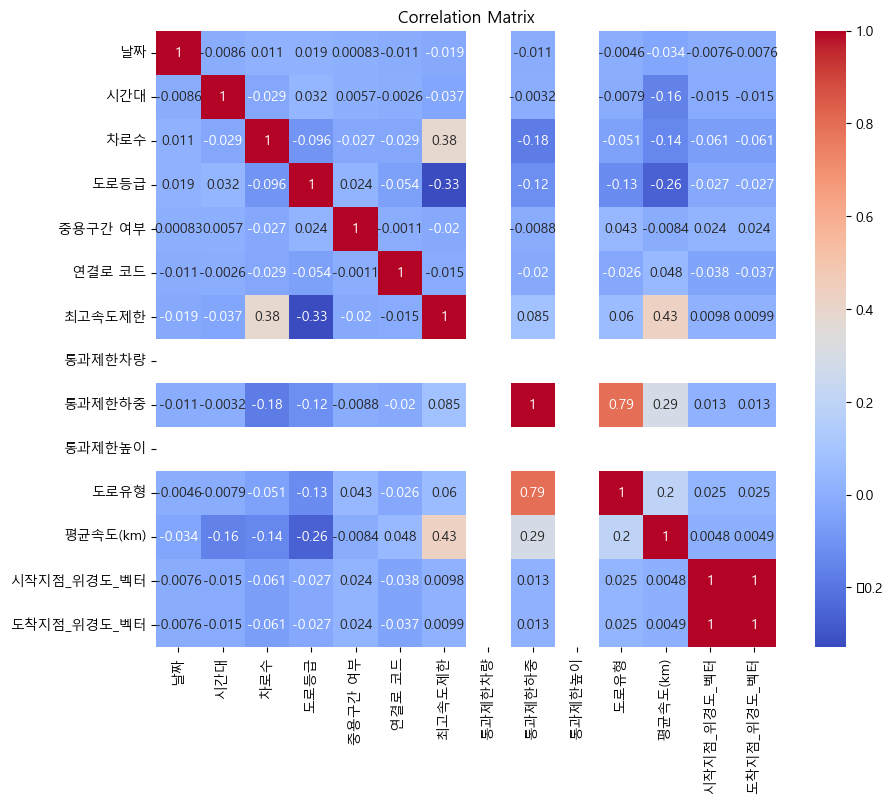

In [16]:
numeric_columns = train.select_dtypes(include='number')

# 상관관계 계산
correlation_matrix = numeric_columns.corr(method = 'pearson')
correlation_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [17]:
train.head()

,날짜,요일,시간대,차로수,도로등급,도로명,중용구간 여부,연결로 코드,최고속도제한,통과제한차량,통과제한하중,통과제한높이,도로유형,시작지점명,시작 지점의 회전제한 유무,도착지점명,도작지점의 회전제한 유무,평균속도(km),시작지점_위경도_벡터,도착지점_위경도_벡터
0,20220623,목,17,1,106,지방도1112호선,0,0,60.0,0.0,32400.0,0.0,3,제3교래교,없음,제3교래교,없음,52.0,130.999357,130.999090
1,20220728,목,21,2,103,일반국도11호선,0,0,60.0,0.0,0.0,0.0,0,광양사거리,있음,KAL사거리,없음,30.0,130.888937,130.887210
2,20211010,일,7,2,103,일반국도16호선,0,0,80.0,0.0,0.0,0.0,0,창고천교,없음,상창육교,없음,61.0,130.677175,130.671173
3,20220311,금,13,2,107,태평로,0,0,50.0,0.0,0.0,0.0,0,남양리조트,없음,서현주택,없음,20.0,130.860839,130.859764
4,20211005,화,8,2,103,일반국도12호선,0,0,80.0,0.0,0.0,0.0,0,애월샷시,없음,애월입구,없음,38.0,130.683271,130.686870


# object 랑 category 파일을 다 숫자형으로 변환

In [18]:
text_columns = train.select_dtypes(include=['object', 'category'])

In [19]:
text_columns

,요일,도로명,시작지점명,시작 지점의 회전제한 유무,도착지점명,도작지점의 회전제한 유무
0,목,지방도1112호선,제3교래교,없음,제3교래교,없음
1,목,일반국도11호선,광양사거리,있음,KAL사거리,없음
2,일,일반국도16호선,창고천교,없음,상창육교,없음
3,금,태평로,남양리조트,없음,서현주택,없음
4,화,일반국도12호선,애월샷시,없음,애월입구,없음
...,...,...,...,...,...,...
4701212,목,-,대림사거리,없음,금덕해운,없음
4701213,목,-,광삼교,없음,광삼교,없음
4701214,월,일반국도12호선,고성교차로,없음,성산교차로,없음
4701215,수,일반국도95호선,제6광령교,없음,관광대학입구,없음


In [20]:
day_mapping = {
    '월': 0,
    '화': 1,
    '수': 2,
    '목': 3,
    '금': 4,
    '토': 5,
    '일': 6
}

# "요일" 변수를 수치형으로 변환
train['요일_숫자형'] = train['요일'].map(day_mapping)
test['요일_숫자형'] = test['요일'].map(day_mapping)


# 데이터프레임에서 단일한 '-'을 0으로 바꾸는 함수 정의
def replace_single_dash_with_zero(df):
    return df.replace(r'^-$', 0, regex=True)

# 데이터프레임의 모든 칼럼에 대해 단일한 '-'을 0으로 바꾸기
train = replace_single_dash_with_zero(train)

In [21]:
def label_encode_feature(df, column):
    le = LabelEncoder()
    encoded_feature = le.fit_transform(df[column])
    return encoded_feature

train['시작지점명_encoded'] = label_encode_feature(train, '시작지점명')
test['시작지점명_encoded'] = label_encode_feature(test, '시작지점명')

train['도착지점명_encoded'] = label_encode_feature(train, '도착지점명')
test['도착지점명_encoded'] = label_encode_feature(test, '도착지점명')

train['시작 지점의 회전제한 유무_encoded'] = label_encode_feature(train, '시작 지점의 회전제한 유무')
test['시작 지점의 회전제한 유무_encoded'] = label_encode_feature(test, '시작 지점의 회전제한 유무')

train['도작지점의 회전제한 유무_encoded'] = label_encode_feature(train, '도작지점의 회전제한 유무')
test['도작지점의 회전제한 유무_encoded'] = label_encode_feature(test, '도작지점의 회전제한 유무')

In [22]:
train.head()

,날짜,요일,시간대,차로수,도로등급,도로명,중용구간 여부,연결로 코드,최고속도제한,통과제한차량,...,도착지점명,도작지점의 회전제한 유무,평균속도(km),시작지점_위경도_벡터,도착지점_위경도_벡터,요일_숫자형,시작지점명_encoded,도착지점명_encoded,시작 지점의 회전제한 유무_encoded,도작지점의 회전제한 유무_encoded
0,20220623,목,17,1,106,지방도1112호선,0,0,60.0,0.0,...,제3교래교,없음,52.0,130.999357,130.999090,3,386,386,0,0
1,20220728,목,21,2,103,일반국도11호선,0,0,60.0,0.0,...,KAL사거리,없음,30.0,130.888937,130.887210,3,32,2,1,0
2,20211010,일,7,2,103,일반국도16호선,0,0,80.0,0.0,...,상창육교,없음,61.0,130.677175,130.671173,6,426,179,0,0
3,20220311,금,13,2,107,태평로,0,0,50.0,0.0,...,서현주택,없음,20.0,130.860839,130.859764,4,58,203,0,0
4,20211005,화,8,2,103,일반국도12호선,0,0,80.0,0.0,...,애월입구,없음,38.0,130.683271,130.686870,1,267,269,0,0


In [23]:
train.drop(['요일', '시작지점명','도착지점명', '시작 지점의 회전제한 유무',
            '도작지점의 회전제한 유무', '도로명'], 
           axis=1, inplace=True)
test.drop(['요일', '시작지점명','도착지점명', '시작 지점의 회전제한 유무',
            '도작지점의 회전제한 유무', '도로명'], 
           axis=1, inplace=True)

In [24]:
train['요일_숫자형'] = train['요일_숫자형'].astype('int32')

In [25]:
train_x = train.drop(columns=['평균속도(km)'])
train_y = train['평균속도(km)']
test_x = test

In [26]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2,
                                                  random_state = 42)

In [ ]:
xgb_model = xgb.XGBRegressor()

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV를 사용하여 최적의 파라미터 값을 찾습니다.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=cv,
                          )
grid_search.fit(train_x, train_y)

# 최적의 파라미터와 점수 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score: ", np.sqrt(-grid_search.best_score_))

# 최적의 파라미터로 학습된 모델 사용
best_model = grid_search.best_estimator_

# 계절별

In [155]:
m_1 = train[train['날짜'].astype(str).str[:6] == '202201']
m_2 = train[train['날짜'].astype(str).str[:6] == '202202']
m_3 = train[train['날짜'].astype(str).str[:6] == '202203']
m_4 = train[train['날짜'].astype(str).str[:6] == '202204']
m_5 = train[train['날짜'].astype(str).str[:6] == '202205']
m_6 = train[train['날짜'].astype(str).str[:6] == '202206']
m_7 = train[train['날짜'].astype(str).str[:6] == '202207']
#8월 데이터는 없음
#m_8 = train[train['날짜'].astype(str).str[:6] == '202108']
m_9 = train[train['날짜'].astype(str).str[:6] == '202109']
m_10 = train[train['날짜'].astype(str).str[:6] == '202110']
m_11 = train[train['날짜'].astype(str).str[:6] == '202111']
m_12 = train[train['날짜'].astype(str).str[:6] == '202112']

In [156]:
spring = m_3 + m_4 + m_5
summer = m_6 + m_7 
fall = m_9 + m_10 + m_11
winter = m_12 + m_1 + m_2

In [174]:
date = pd.DataFrame({'season':['Spring','Summer','Fall','Winter'],
                     'count' : [969380,765732,1229803,1736202]})

In [175]:
date

,season,count
0,Spring,969380
1,Summer,765732
2,Fall,1229803
3,Winter,1736202


In [198]:
print((969380 / 4701217) * 100)
print((765732 / 4701217) * 100)
print((1229803 / 4701217) * 100)
print((1736202 / 4701217) * 100)

20.6197671794346
16.287952672680287
26.159247701180355
36.93090533791569


Text(2.8, 1750000, '36.93%')

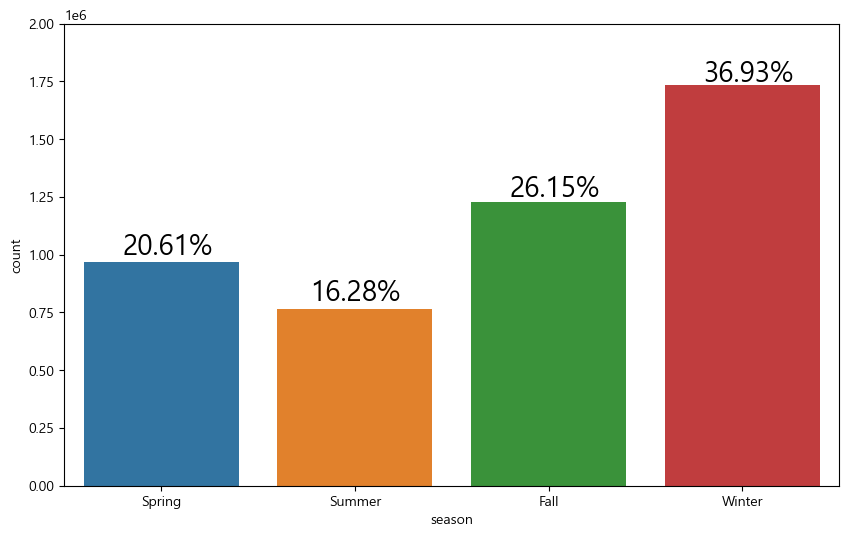

In [246]:
fig, dateplot = plt.subplots(figsize = (10,6), dpi = 100)
dateplot = sns.barplot(x = 'season', y = 'count', data=date)
dateplot.set_ylim(bottom=0, top=2000000)
dateplot.text(x = -0.2,y = 1000000, s='20.61%', fontsize= 20)
dateplot.text(x = 0.77,y = 800000, s='16.28%', fontsize= 20)
dateplot.text(x = 1.8,y = 1250000, s='26.15%', fontsize= 20)
dateplot.text(x = 2.8,y = 1750000, s='36.93%', fontsize= 20)

In [131]:
train['날짜'].astype('string')

430379     20210901
369019     20210901
1132647    20210901
4543127    20210901
3428956    20210901
             ...   
2053638    20220731
2748124    20220731
2447938    20220731
3749761    20220731
4680098    20220731
Name: 날짜, Length: 4701217, dtype: string

In [146]:
date = train['날짜']
date

430379     20210901
1189451    20210901
1827335    20210901
4521509    20210901
1108258    20210901
             ...   
59263      20220731
78463      20220731
701478     20220731
1518849    20220731
4680098    20220731
Name: 날짜, Length: 4701217, dtype: int64

In [147]:
date.loc[(date >= 20210901) & (date < 20211001)].count()

570909

In [148]:
date.loc[(date >= 202101001) & (date < 20211101)].count()

0

In [137]:
train['날짜'].loc[202110:202111]

202110     20211102
358000     20211102
1783749    20211102
430270     20211102
4513994    20211102
             ...   
253050     20220517
2274783    20220517
4697490    20220517
3724342    20220517
202111     20220517
Name: 날짜, Length: 2611329, dtype: int64

In [82]:
train['날짜'].dtypes

dtype('int64')

In [152]:
train['날짜'].sort_values(ascending = True)

430379     20210901
1497100    20210901
4617679    20210901
369019     20210901
1132647    20210901
             ...   
4635304    20220731
3457292    20220731
2053638    20220731
444187     20220731
4680098    20220731
Name: 날짜, Length: 4701217, dtype: int64

# 요일별

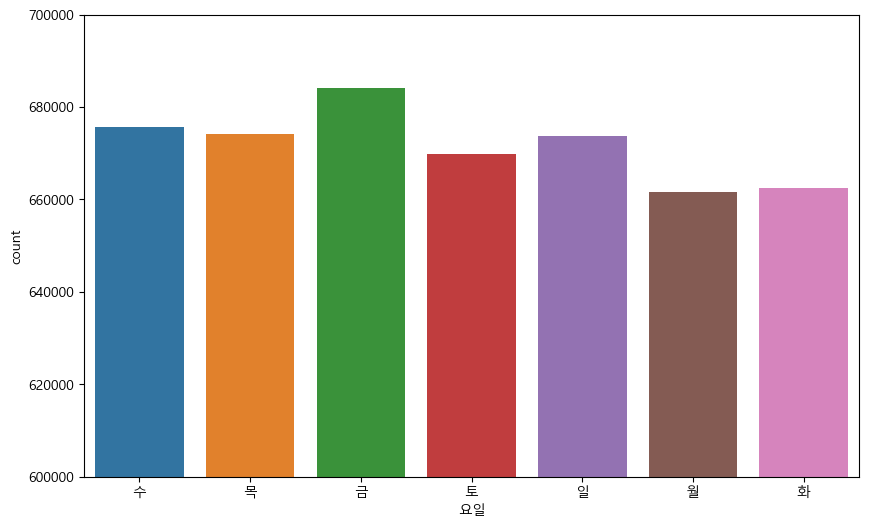

In [253]:
fig, dayplot = plt.subplots(figsize = (10,6), dpi = 100)
dayplot = sns.countplot(x = '요일', data=train)
dayplot.set_ylim(bottom=600000, top=700000);

## 시간별

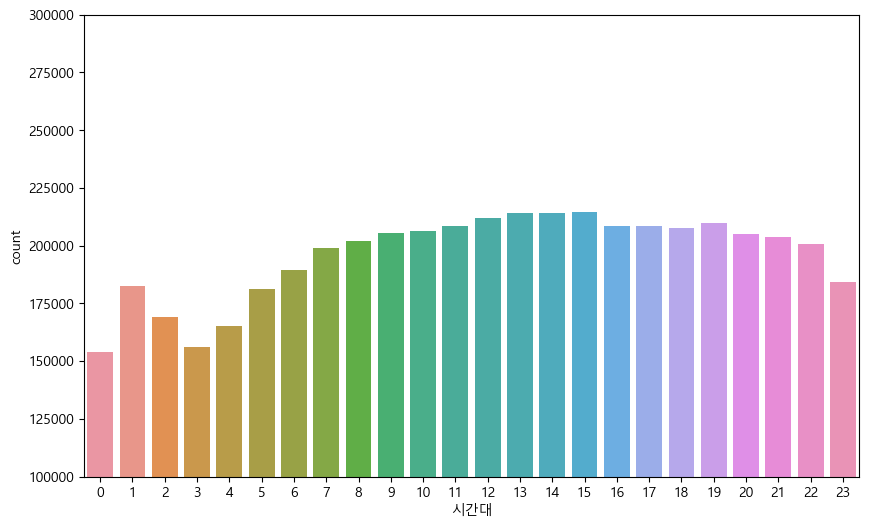

In [63]:
fig, dayplot = plt.subplots(figsize = (10,6), dpi = 100)
dayplot = sns.countplot(x = '시간대', data=train)
dayplot.set_ylim(bottom=100000, top=300000);

In [28]:
train.groupby("시간대")["평균속도(km)"].count().sort_values(ascending=True)

시간대
0     154158
3     155938
4     165284
2     169322
5     181128
1     182353
23    184229
6     189418
7     199061
22    200629
8     201875
21    203585
20    205059
9     205327
10    206316
18    207500
17    208377
16    208420
11    208515
19    209870
12    211833
14    214182
13    214297
15    214541
Name: 평균속도(km), dtype: int64

In [29]:
train.groupby("시간대")["평균속도(km)"].value_counts(ascending = False)

시간대  평균속도(km)
0    52.0        4546
     51.0        4545
     50.0        4529
     54.0        4311
     49.0        4149
                 ... 
23   87.0          11
     2.0            9
     88.0           5
     92.0           2
     1.0            1
Name: 평균속도(km), Length: 2100, dtype: int64

In [31]:
for i in range(24):
    mean_time = train[train["시간대"] == i]["평균속도(km)"].mean()
    print("{}시의 평균 속도는 {} km 입니다.".format(i, mean_time))

0시의 평균 속도는 48.74219956148886 km 입니다.
1시의 평균 속도는 49.76329975377427 km 입니다.
2시의 평균 속도는 50.27865841414583 km 입니다.
3시의 평균 속도는 50.54325437032667 km 입니다.
4시의 평균 속도는 49.747525471309984 km 입니다.
5시의 평균 속도는 47.20113952563933 km 입니다.
6시의 평균 속도는 45.549029131339154 km 입니다.
7시의 평균 속도는 43.682268249431075 km 입니다.
8시의 평균 속도는 41.65629226006192 km 입니다.
9시의 평균 속도는 40.87593935527232 km 입니다.
10시의 평균 속도는 40.22223191608988 km 입니다.
11시의 평균 속도는 39.82459295494329 km 입니다.
12시의 평균 속도는 39.83853790485902 km 입니다.
13시의 평균 속도는 39.73147080920405 km 입니다.
14시의 평균 속도는 39.561120915856606 km 입니다.
15시의 평균 속도는 39.35169967512037 km 입니다.
16시의 평균 속도는 39.127929181460516 km 입니다.
17시의 평균 속도는 38.47336318307683 km 입니다.
18시의 평균 속도는 38.2412578313253 km 입니다.
19시의 평균 속도는 40.10411206937628 km 입니다.
20시의 평균 속도는 41.11380627039048 km 입니다.
21시의 평균 속도는 42.17343124493455 km 입니다.
22시의 평균 속도는 43.989861884373646 km 입니다.
23시의 평균 속도는 45.807739281003535 km 입니다.


In [32]:
train.groupby("시간대")["평균속도(km)"].mean().sort_values(ascending = False)

시간대
3     50.543254
2     50.278658
1     49.763300
4     49.747525
0     48.742200
5     47.201140
23    45.807739
6     45.549029
22    43.989862
7     43.682268
21    42.173431
8     41.656292
20    41.113806
9     40.875939
10    40.222232
19    40.104112
12    39.838538
11    39.824593
13    39.731471
14    39.561121
15    39.351700
16    39.127929
17    38.473363
18    38.241258
Name: 평균속도(km), dtype: float64

<AxesSubplot:ylabel='평균속도(km)'>

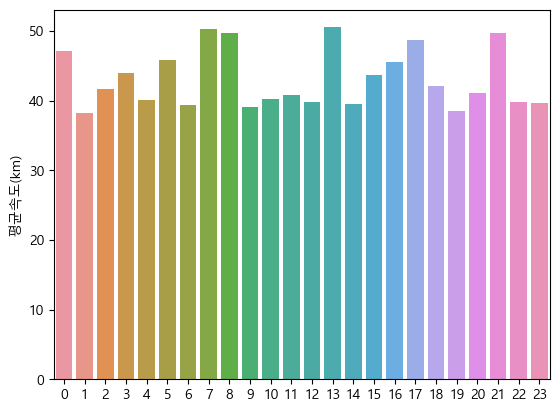

In [35]:
sns.barplot(x = train.시간대.unique(), y = train.groupby("시간대")["평균속도(km)"].mean())